In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from numpy import *
%matplotlib notebook

In [2]:
cd cc2/

/home/selimb/School/schoolstuff/mech546/project1/truss/cc2


In [11]:
U = np.loadtxt('U.out', delimiter=',')
S = np.loadtxt('S.out', delimiter=',')
all_node_locs = np.loadtxt('node_locs.csv', skiprows=1, delimiter=',')
num_nodes = len(all_node_locs)
connectivity = np.loadtxt('connectivity.csv', skiprows=1, delimiter=',', dtype=int)
connectivity = connectivity - 1
num_elems = len(connectivity)
ndims = 3

In [4]:
def mk_sctr(nodeIDs):
    sctr = []
    for I in nodeIDs:
        dofs = [ndims*I + i for i in range(ndims)]
        sctr = sctr + dofs
    return sctr

In [5]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

<IPython.core.display.Javascript object>


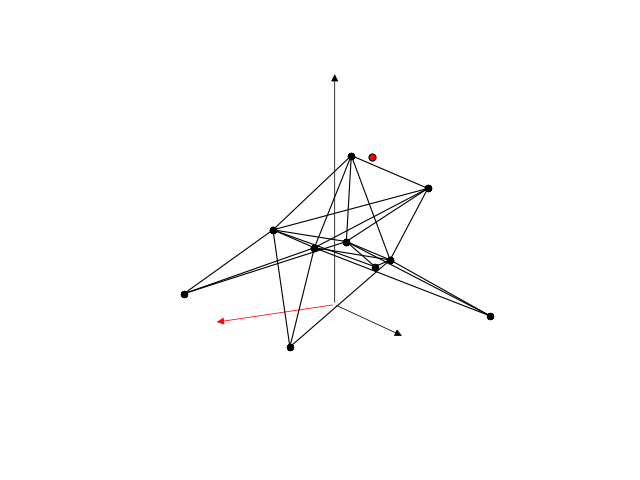

[-0.9525  0.      5.08  ]
[ -2.42830000e+00  -5.29130000e-17   3.71760000e+00]


In [6]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for elem in range(num_elems):
    nodes = connectivity[elem]
    old_locs = all_node_locs[nodes] # 2 x 3
#     ax.plot(old_locs[:,0], old_locs[:,1], old_locs[:,2], 'k--o')
    sctr = mk_sctr(nodes)
    disp = U[sctr].reshape((2, 3))
    new_locs = old_locs + disp*10000
    ax.plot(new_locs[:,0], new_locs[:,1], new_locs[:,2], 'k-o')
    

applied_node = 0
old_loc = all_node_locs[0]
new_loc = old_loc + U[0:3]*10000
ax.scatter(old_loc[0], old_loc[1], old_loc[2], s=40, c='r')
# Coordinate System

xmax = np.max(all_node_locs[:,0])
ymax = np.max(all_node_locs[:,1])
zmax = np.max(all_node_locs[:,2])
a = Arrow3D([0, xmax*1.2], [0, 0], [0, 0], mutation_scale=15, lw=0.7, arrowstyle="-|>", color="r")
ax.add_artist(a)
a = Arrow3D([0, 0], [0, ymax*1.2], [0, 0], mutation_scale=15, lw=0.7, arrowstyle="-|>", color="k")
ax.add_artist(a)
a = Arrow3D([0, 0], [0, 0], [0, zmax*1.6], mutation_scale=15, lw=0.7, arrowstyle="-|>", color="k")
ax.add_artist(a)
ax.grid(False)
ax.set_axis_off()
# arrow = Arrow3D([0, xmax], [0, 0], [0, 0], color='k', arrowstyle='-|>', lw=3, mutation_scale=20)
# ax.add_artist(arrow)
# ax.plot([0, 100], [0, 0], [0, 0], 'b')
# ax.plot([0, 0], [0, 100], [0, 0], 'g')
# ax.plot([0, 0], [0, 0], [0, 100], 'r')
#     new_locs[:, 0] += disp
# ax.view_init(0, 0)
#     ax.plot([node1[0]])
#     ax.plot(x0, y0, z0)

In [7]:
def mk_line(name, vals):
    return ' & '.join([name,] + vals) + ' \\\\'

In [45]:
# Make table of displacements
tablehead = r'''\begin{tabular}{@{} l c c c @{}}
    \toprule
    Node \# & $U_x$ (mm) & $U_y$ (mm) & $U_z$ (mm) \\
    \midrule
'''
tablefoot = r'''
    \bottomrule
\end{tabular}'''
lines = []
Ur = U.reshape((num_nodes, ndims))*1000
FMT = '%8.4f'
for node in range(num_nodes):
    disps = Ur[node]
    name = '%2i' % (node+1)
    vals = [FMT % d for d in disps]
    line = mk_line(name, vals)
    lines.append(line)

Urabs = np.abs(Ur)
UextrmIDs = np.zeros((2, ndims))
Uextrmvals = np.zeros_like(UextrmIDs)
names = ['Maximum', 'Minimum']
for i in range(ndims):
    maxidx = Urabs[:,i].argmax()
    minidx = Urabs[:,i].argmin()
    UextrmIDs[0, i] = maxidx
    UextrmIDs[1, i] = minidx
    Uextrmvals[0, i] = Urabs[maxidx,i]
    Uextrmvals[1, i] = Urabs[minidx,i]
    
for i in range(2):
    name = names[i]
    vals = [FMT % d for d in Uextrmvals[i,:]]
    line = mk_line(name, vals)
    lines.append(line)
    name = 'Node \#'
    vals = ['%2i' % (ID+1) for ID in UextrmIDs[i,:]]
    line = mk_line(name, vals)
    lines.append(line)
    
body = '\n'.join(lines)
utable = '\n'.join([tablehead, body, tablefoot])
print(utable)

\begin{tabular}{@{} l c c c @{}}
    \toprule
    Node \# & $U_x$ (mm) & $U_y$ (mm) & $U_z$ (mm) \\
    \midrule

 1 &  -0.1476 &  -0.0000 &  -0.1362 \\
 2 &  -0.1376 &   0.0000 &   0.0125 \\
 3 &   0.0089 &   0.0031 &  -0.0764 \\
 4 &   0.0100 &   0.0005 &   0.0019 \\
 5 &   0.0100 &  -0.0005 &   0.0019 \\
 6 &   0.0089 &  -0.0031 &  -0.0764 \\
 7 &   0.0000 &   0.0000 &   0.0000 \\
 8 &   0.0000 &   0.0000 &   0.0000 \\
 9 &   0.0000 &   0.0000 &   0.0000 \\
10 &   0.0000 &   0.0000 &   0.0000 \\
Maximum &   0.1476 &   0.0031 &   0.1362 \\
Node \# &  1 &  3 &  1 \\
Minimum &   0.0000 &   0.0000 &   0.0000 \\
Node \# &  7 &  7 &  7 \\

    \bottomrule
\end{tabular}


In [49]:
# Make stress table
tablehead = r'''\begin{tabular}{@{} r r @{}}
    \toprule
    Element \# & Stress (KPa) \\
    \midrule
'''
tablefoot = r'''
    \bottomrule
\end{tabular}'''
lines = []
FMT = '%7.1f'
SS = S/(10**3)
for elem in range(num_elems):
    name = '%2i' % (elem+1)
    vals = [FMT % SS[elem]]
    line = mk_line(name, vals)
    lines.append(line)

idxmax = SS.argmax()
idxmin = SS.argmin()
SextrmIDs = [idxmax, idxmin]
SextrmVals = [SS[idxmax], SS[idxmin]]
names = ['Maximum', 'Minimum']
    
for i in range(2):
    name = names[i]
    vals = [FMT % SextrmVals[i]]
    line = mk_line(name, vals)
    lines.append(line)
    name = 'Element \#'
    vals = ['%2i' % (SextrmIDs[i] + 1)]
    line = mk_line(name, vals)
    lines.append(line)
    
body = '\n'.join(lines)
stable = '\n'.join([tablehead, body, tablefoot])
print(stable)

\begin{tabular}{@{} r r @{}}
    \toprule
    Element \# & Stress (KPa) \\
    \midrule

 1 &   362.2 \\
 2 &  -315.1 \\
 3 &  -315.1 \\
 4 &  -315.1 \\
 5 &  -315.1 \\
 6 &   257.9 \\
 7 &   257.9 \\
 8 & -1397.5 \\
 9 & -1397.5 \\
10 &   221.6 \\
11 &    34.1 \\
12 &    40.4 \\
13 &    40.4 \\
14 &  -551.7 \\
15 &  -551.7 \\
16 &   -30.8 \\
17 &   -30.8 \\
18 &   127.4 \\
19 &  -750.0 \\
20 &   127.4 \\
21 &  -750.0 \\
22 & -1109.6 \\
23 & -1109.6 \\
24 &   -71.2 \\
25 &   -71.2 \\
Maximum &   362.2 \\
Element \# &  1 \\
Minimum & -1397.5 \\
Element \# &  8 \\

    \bottomrule
\end{tabular}


In [38]:
import os
import subprocess
from IPython.display import Image

In [50]:
def preview(table):
    tex = r'''\documentclass{article}
    \usepackage{booktabs}
    \begin{document}
    \begin{table}
    \centering
    %s
    \end{table}
    \end{document}
    ''' % table
    if not os.path.exists('textemp'):
        os.mkdir('textemp')
    open('textemp/main.tex', 'w').write(tex)
#     os.chdir('textemp')
    print(subprocess.check_output(['pdflatex', 'main.tex'], cwd='textemp'))
    print(subprocess.check_output(['evince', 'textemp/main.pdf']))
#     os.chdir('..')

In [51]:
preview(stable)

This is pdfTeX, Version 3.1415926-2.5-1.40.14 (TeX Live 2013/Debian)
 restricted \write18 enabled.
entering extended mode
(./main.tex
LaTeX2e <2011/06/27>
Babel <3.9h> and hyphenation patterns for 2 languages loaded.
(/usr/share/texlive/texmf-dist/tex/latex/base/article.cls
Document Class: article 2007/10/19 v1.4h Standard LaTeX document class
(/usr/share/texlive/texmf-dist/tex/latex/base/size10.clo))
(/home/selimb/texmf/tex/latex/booktabs/booktabs.sty) (./main.aux) [1{/home/seli
mb/.texmf-var/fonts/map/pdftex/updmap/pdftex.map}] (./main.aux) )</usr/share/te
xlive/texmf-dist/fonts/type1/public/amsfonts/cm/cmr10.pfb>
Output written on main.pdf (1 page, 16802 bytes).
Transcript written on main.log.


